<a href="https://colab.research.google.com/github/RFA863/VAE_models_for_reconstruct_dataset/blob/main/VAE_Indonesia_Tourism_Destination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import warnings

# Mengabaikan UserWarning yang tidak kritikal dari Keras
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# =============================================================================
# 1. PERSIAPAN DATA DAN LINGKUNGAN
# =============================================================================
print("TensorFlow version:", tf.__version__)

# Cek lingkungan (Colab atau lokal) dan muat data
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/dataset/Indonesia_Tourism_Destination_Dataset/tourism_rating.csv'
    original_data_path = '/content/drive/My Drive/dataset/Indonesia_Tourism_Destination_Dataset/tourism_with_id.csv'
    output_dir = '/content/drive/My Drive/vae_output/'
    if not os.path.exists(data_path):
        raise FileNotFoundError("File tidak ditemukan di Google Drive.")
except Exception as e:
    print(f"Error: {e}. Menggunakan path lokal.")
    data_path = 'tourism_rating.csv'
    original_data_path = 'tourism_with_id.csv'
    output_dir = './vae_output/'

# Buat direktori output jika belum ada
os.makedirs(output_dir, exist_ok=True)
print(f"Direktori output akan berada di: {output_dir}")

# Memuat dataset
try:
    raw_data_rating = pd.read_csv(data_path)
    places_df = pd.read_csv(original_data_path)
    print("Dataset berhasil dimuat.")
except FileNotFoundError:
    print(f"FATAL ERROR: Pastikan file '{data_path}' dan '{original_data_path}' ada di direktori kerja.")
    exit()


# Pra-pemrosesan data dasar
raw_df = raw_data_rating[['User_Id','Place_Id']].copy()
raw_df.columns = ['user_id','item_id']
# Mengonversi ID agar dimulai dari 0
raw_df['user_id'] -= 1
raw_df['item_id'] -= 1

# Fungsi untuk filtering data
def get_count(df, col): return df.groupby(col).size()
def filter_triplets(df, min_user_count=5, min_item_count=0):
    if min_user_count > 0:
        user_counts = get_count(df, 'user_id')
        df = df[df['user_id'].isin(user_counts.index[user_counts >= min_user_count])]
    if min_item_count > 0:
        item_counts = get_count(df, 'item_id')
        df = df[df['item_id'].isin(item_counts.index[item_counts >= min_item_count])]
    return df, get_count(df, 'user_id'), get_count(df, 'item_id')

# Melakukan filtering dan remapping ID
data, user_activity, item_popularity = filter_triplets(raw_df, min_user_count=5)

# Remapping User ID
unique_user_ids = user_activity.index
n_users = len(unique_user_ids)
user_map = {old_id: new_id for new_id, old_id in enumerate(unique_user_ids)}
data['user_id'] = data['user_id'].map(user_map)

# Remapping Item ID
unique_item_ids = item_popularity.index
n_items = len(unique_item_ids)
item_map = {old_id: new_id for new_id, old_id in enumerate(unique_item_ids)}
data['item_id'] = data['item_id'].map(item_map)

data.dropna(inplace=True)
data[['user_id','item_id']] = data[['user_id','item_id']].astype(int)

# Menampilkan statistik data setelah filtering
print("-" * 30)
print(f"Jumlah Pengguna Aktif: {n_users}")
print(f"Jumlah Item Populer: {n_items}")
print(f"Jumlah Interaksi: {len(data)}")
print(f"Sparsity: {1 - len(data) / (n_users * n_items):.2%}")
print("-" * 30)


# Pembagian data Train/Validation/Test dengan proporsi 70/15/15
def split_train_test_proportion(df, test_prop):
    tr_list, te_list = [], []
    np.random.seed(42) # Seed untuk reproduktibilitas
    for _, group in df.groupby('user_id'):
        n_items_u = len(group)
        test_size = int(round(test_prop * n_items_u))
        if n_items_u >= 5 and test_size > 0:
            idx = np.zeros(n_items_u, dtype=bool)
            idx[np.random.choice(n_items_u, test_size, replace=False)] = True
            tr_list.append(group[~idx])
            te_list.append(group[idx])
        else:
            tr_list.append(group)
    return pd.concat(tr_list), pd.concat(te_list)

train_data, rest_data = split_train_test_proportion(data, 0.3)
validation_data, test_data = split_train_test_proportion(rest_data, 0.5)
print(f"Ukuran data split: Train={len(train_data)}, Validation={len(validation_data)}, Test={len(test_data)}")

# Membuat matriks sparse
train_matrix = sparse.csr_matrix((np.ones(len(train_data)), (train_data.user_id, train_data.item_id)), shape=(n_users, n_items))
validation_matrix = sparse.csr_matrix((np.ones(len(validation_data)), (validation_data.user_id, validation_data.item_id)), shape=(n_users, n_items))
test_matrix = sparse.csr_matrix((np.ones(len(test_data)), (test_data.user_id, test_data.item_id)), shape=(n_users, n_items))



TensorFlow version: 2.18.0
Mounted at /content/drive
Direktori output akan berada di: /content/drive/My Drive/vae_output/
Dataset berhasil dimuat.
------------------------------
Jumlah Pengguna Aktif: 300
Jumlah Item Populer: 437
Jumlah Interaksi: 10000
Sparsity: 92.37%
------------------------------
Ukuran data split: Train=7007, Validation=1504, Test=1489


In [ ]:
# =============================================================================
# 2. DEFINISI MODEL VAE, METRIK, DAN CALLBACK
# =============================================================================
@tf.keras.utils.register_keras_serializable()
class VAE(Model):
    def __init__(self, n_items, p_dims, anneal_cap=0.2, total_anneal_steps=100000.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.n_items_arg = n_items
        self.p_dims_arg = p_dims
        self.anneal_cap_arg = anneal_cap
        self.total_anneal_steps_arg = total_anneal_steps

        self.latent_dim = p_dims[0]
        self.encoder_h = Dense(p_dims[1], activation='tanh', name='encoder_hidden')
        self.encoder_mean = Dense(self.latent_dim, name='encoder_mean')
        self.encoder_log_var = Dense(self.latent_dim, name='encoder_log_var')
        self.decoder_h = Dense(p_dims[1], activation='tanh', name='decoder_hidden')
        self.decoder_mean = Dense(n_items, activation='sigmoid', name='decoder_output')

        self.anneal_cap = tf.constant(anneal_cap, dtype=tf.float32)
        self.total_anneal_steps = tf.constant(total_anneal_steps, dtype=tf.float32)
        self.update_count = tf.Variable(0., trainable=False)

    def encode(self, inputs):
        h = self.encoder_h(inputs)
        return self.encoder_mean(h), self.encoder_log_var(h)

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def decode(self, z):
        h = self.decoder_h(z)
        return self.decoder_mean(h)

    def call(self, inputs, training=False):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)

        if training:
            self.update_count.assign_add(1.0)

        reconstruction_loss = self.n_items_arg * tf.keras.losses.binary_crossentropy(inputs, reconstructed)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

        anneal = tf.minimum(self.anneal_cap, self.update_count / self.total_anneal_steps)
        total_loss = tf.reduce_mean(reconstruction_loss + anneal * kl_loss)

        self.add_loss(total_loss)
        return reconstructed

    def get_config(self):
        config = super().get_config()
        config.update({
            'n_items': self.n_items_arg,
            'p_dims': self.p_dims_arg,
            'anneal_cap': self.anneal_cap_arg,
            'total_anneal_steps': self.total_anneal_steps_arg
        })
        return config

# Fungsi metrik evaluasi
def ndcg_at_k(recon_matrix, true_matrix, k):
    top_k_indices = np.argpartition(-recon_matrix, k, axis=1)[:, :k]
    true_binary = true_matrix.toarray() > 0
    gains = np.take_along_axis(true_binary, top_k_indices, 1)
    discounts = np.log2(np.arange(k) + 2)
    dcg = (gains / discounts).sum(1)

    ideal_gains = np.zeros_like(gains)
    num_true = true_binary.sum(axis=1)
    for i, n in enumerate(num_true):
        ideal_gains[i, :int(min(n, k))] = 1
    idcg = (ideal_gains / discounts).sum(1)

    return np.mean(dcg / np.maximum(idcg, 1))

def precision_recall_at_k(recon_matrix, true_matrix, k):
    top_k_indices = np.argpartition(-recon_matrix, k, axis=1)[:, :k]

    # Buat mask untuk item yang direkomendasikan
    recommendation_mask = np.zeros_like(recon_matrix, dtype=bool)
    rows = np.repeat(np.arange(recon_matrix.shape[0]), k)
    cols = top_k_indices.flatten()
    recommendation_mask[rows, cols] = True

    true_binary = true_matrix.toarray() > 0
    hits = (recommendation_mask & true_binary).sum(1)

    precision = hits / k
    recall = hits / np.maximum(1, true_binary.sum(1))
    return np.mean(precision), np.mean(recall)

# Callback untuk menghitung metrik pada setiap epoch
class MetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_mask, validation_matrix, k):
        super().__init__()
        self.mask = train_mask.toarray().astype(bool)
        self.validation_matrix = validation_matrix
        self.k = k
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        reconstructed = self.model.predict(self.validation_matrix.toarray(), verbose=0)
        reconstructed[self.mask] = -np.inf
        logs[f'val_ndcg@{self.k}'] = ndcg_at_k(reconstructed, self.validation_matrix, self.k)

# Generator data untuk training
def generate(batch_size, matrix):
    while True:
        shuffled_indices = np.random.permutation(matrix.shape[0])
        for i in range(0, matrix.shape[0], batch_size):
            batch_indices = shuffled_indices[i:i+batch_size]
            batch = matrix[batch_indices].toarray()
            yield batch, batch


In [ ]:
# =============================================================================
# 3. HYPERPARAMETER TUNING
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 3: MEMULAI HYPERPARAMETER TUNING ---"); print("="*50)
param_grid = {
    'latent_dim': [128, 256],
    'anneal_cap': [0.1, 0.2],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [128, 256],
    'optimizer': ['Adam', 'RMSprop', 'Nadam', 'Adamax']
}
best_score = -1
best_params = None
best_history = None
tuning_results = []
K_EVAL = 100

# Menghitung total konfigurasi untuk ditampilkan
grid = list(ParameterGrid(param_grid))
total_configs = len(grid)
print(f"Total konfigurasi yang akan diuji: {total_configs}")

for i, params in enumerate(grid):
    print("\n" + "-"*20 + f" Menguji Konfigurasi {i+1}/{total_configs} " + "-"*20)
    print(f"Parameter: {params}")

    p_dims = [params['latent_dim'], 600]
    model = VAE(n_items, p_dims, params['anneal_cap'])

    optimizer_class = getattr(tf.keras.optimizers, params['optimizer'])
    optimizer = optimizer_class(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss=None)

    metric_callback = MetricCallback(train_matrix, validation_matrix, K_EVAL)
    early_stopping = EarlyStopping(monitor=f'val_ndcg@{K_EVAL}', mode='max', patience=20, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0)

    history = model.fit(
        generate(params['batch_size'], train_matrix),
        steps_per_epoch=int(np.ceil(n_users / params['batch_size'])),
        epochs=150,
        callbacks=[metric_callback, early_stopping, reduce_lr],
        validation_data=generate(params['batch_size'], validation_matrix),
        validation_steps=int(np.ceil(n_users / params['batch_size'])),
        verbose=0
    )

    stopped_epoch = len(history.history['loss'])
    score = max(history.history[f'val_ndcg@{K_EVAL}'])
    print(f"-> Skor val_ndcg@{K_EVAL} tertinggi: {score:.4f} (Berhenti pada epoch: {stopped_epoch})")

    tuning_results.append({'params': params, 'score': score, 'stopped_epoch': stopped_epoch})

    if score > best_score:
        best_score, best_params, best_history = score, params, history
        model.save(os.path.join(output_dir, 'best_model.keras'))
        print(f"*** Ditemukan skor terbaik baru! ***")

print("\n" + "="*50); print("--- HASIL HYPERPARAMETER TUNING ---"); print("="*50)
print(f"Parameter terbaik: {best_params}")
print(f"Skor validasi NDCG@{K_EVAL} terbaik: {best_score:.4f}")
pd.DataFrame(tuning_results).to_csv(os.path.join(output_dir, 'grid_search_results.csv'), index=False)




--- TAHAP 3: MEMULAI HYPERPARAMETER TUNING ---
Total konfigurasi yang akan diuji: 64

-------------------- Menguji Konfigurasi 1/64 --------------------
Parameter: {'anneal_cap': 0.1, 'batch_size': 128, 'latent_dim': 128, 'learning_rate': 0.001, 'optimizer': 'Adam'}
-> Skor val_ndcg@100 tertinggi: 0.0941 (Berhenti pada epoch: 50)
*** Ditemukan skor terbaik baru! ***

-------------------- Menguji Konfigurasi 2/64 --------------------
Parameter: {'anneal_cap': 0.1, 'batch_size': 128, 'latent_dim': 128, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}
-> Skor val_ndcg@100 tertinggi: 0.6869 (Berhenti pada epoch: 102)
*** Ditemukan skor terbaik baru! ***

-------------------- Menguji Konfigurasi 3/64 --------------------
Parameter: {'anneal_cap': 0.1, 'batch_size': 128, 'latent_dim': 128, 'learning_rate': 0.001, 'optimizer': 'Nadam'}
-> Skor val_ndcg@100 tertinggi: 0.1405 (Berhenti pada epoch: 60)

-------------------- Menguji Konfigurasi 4/64 --------------------
Parameter: {'anneal_cap': 

In [ ]:
# =============================================================================
# 4. PELATIHAN MODEL FINAL
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 4: MELATIH MODEL FINAL ---"); print("="*50)

# TEMUKAN EPOCH TERBAIK DARI HASIL TUNING
# best_history adalah riwayat dari model dengan performa validasi terbaik
# optimal_epochs = np.argmax(best_history.history[f'val_ndcg@{K_EVAL}']) + 1
# print(f"Berdasarkan tuning, epoch optimal adalah: {optimal_epochs}")


final_train_matrix = train_matrix + validation_matrix
final_p_dims = [best_params['latent_dim'], 600]

final_model = VAE(n_items, final_p_dims, best_params['anneal_cap'])
final_optimizer_class = getattr(tf.keras.optimizers, best_params['optimizer'])
final_optimizer = final_optimizer_class(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss=None)

final_metric_callback = MetricCallback(final_train_matrix, test_matrix, K_EVAL)

# === REKOMENDASI UTAMA: AKTIFKAN KEMBALI EARLY STOPPING ===
# Monitor performa pada test set (yang dihitung oleh MetricCallback Anda)
final_early_stopping = EarlyStopping(
    monitor=f'val_ndcg@{K_EVAL}',
    mode='max',
    patience=20, # Anda bisa sesuaikan patience jika perlu
    restore_best_weights=True # Sangat penting untuk mendapatkan model terbaik
)

final_history = final_model.fit(
    generate(best_params['batch_size'], final_train_matrix),
    steps_per_epoch=int(np.ceil(n_users / best_params['batch_size'])),
    epochs=150,
    #  epochs=optimal_epochs,
    # epochs=len(best_history.history['loss']),
    callbacks=[final_metric_callback, final_early_stopping],
    validation_data=generate(best_params['batch_size'], test_matrix),
    validation_steps=int(np.ceil(n_users / best_params['batch_size'])),
    verbose=1
)
final_model.save(os.path.join(output_dir, 'final_vae_model.keras'))
print("Pelatihan model final selesai.")



--- TAHAP 4: MELATIH MODEL FINAL ---
Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - loss: 305.9516 - val_loss: 184.7073 - val_ndcg@100: 0.0875
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 110.8104 - val_loss: 169.7989 - val_ndcg@100: 0.0853
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 107.6022 - val_loss: 158.1768 - val_ndcg@100: 0.0932
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 106.6131 - val_loss: 164.6719 - val_ndcg@100: 0.0909
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 106.3750 - val_loss: 164.6453 - val_ndcg@100: 0.0908
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 105.9297 - val_loss: 155.1505 - val_ndcg@100: 0.1039
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 104.1906 - val_loss: 162.8946 - val_ndcg@100: 0.0918
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 103.2981 - val_loss: 159.5738 - val_ndcg@100: 0.1062
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 101.832


--- TAHAP 5: VISUALISASI HASIL TRAINING ---


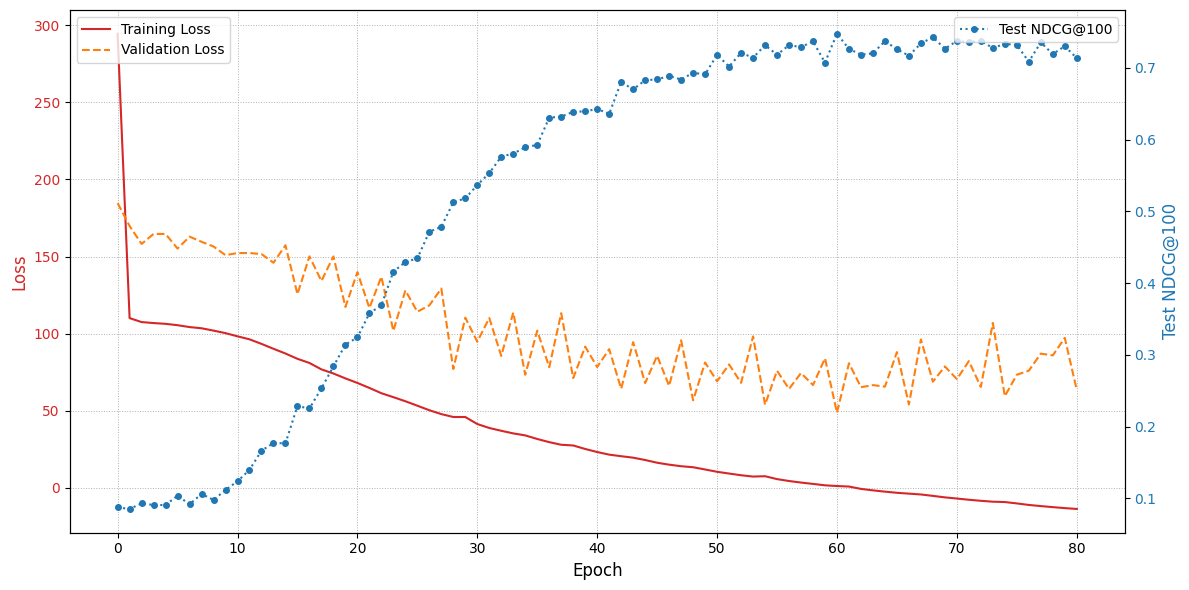

In [ ]:
# =============================================================================
# 5. VISUALISASI HASIL TRAINING FINAL
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 5: VISUALISASI HASIL TRAINING ---"); print("="*50)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Sumbu Y pertama untuk Loss
color = 'tab:red'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', color=color, fontsize=12)
ax1.plot(final_history.history['loss'], color=color, linestyle='-', label='Training Loss')
if 'val_loss' in final_history.history:
    ax1.plot(final_history.history['val_loss'], color='tab:orange', linestyle='--', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle=':', linewidth=0.7)

# Sumbu Y kedua untuk NDCG
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(f'Test NDCG@{K_EVAL}', color=color, fontsize=12)
ax2.plot(final_history.history[f'val_ndcg@{K_EVAL}'], color=color, marker='o', markersize=4, linestyle=':', label=f'Test NDCG@{K_EVAL}')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# plt.title(f'Kurva Training Model Final', fontsize=14)
fig.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curve.png'))
plt.show()


In [ ]:
# =============================================================================
# 6. EVALUASI FINAL DAN PEMBUATAN REKOMENDASI
# =============================================================================
print("\n" + "="*50); print("--- TAHAP 6: EVALUASI & REKOMENDASI ---"); print("="*50)
recon_test_matrix = final_model.predict(test_matrix.toarray(), batch_size=best_params['batch_size'])
train_val_mask = final_train_matrix.toarray().astype(bool)
recon_test_matrix[train_val_mask] = -np.inf

evaluation_metrics = []
for k in [ 5, 10, 15, 20, 25, 30]:
    precision, recall = precision_recall_at_k(recon_test_matrix, test_matrix, k)
    ndcg = ndcg_at_k(recon_test_matrix, test_matrix, k)
    evaluation_metrics.append({'K': k, 'Precision': precision, 'Recall': recall, 'NDCG': ndcg})

eval_df = pd.DataFrame(evaluation_metrics)
print("Hasil Evaluasi Final pada Test Set:")
print(eval_df.to_string(index=False))
eval_df.to_csv(os.path.join(output_dir, 'evaluation_metrics.csv'), index=False)

# Membuat rekomendasi Top-10
full_matrix = final_train_matrix + test_matrix
full_predictions = final_model.predict(full_matrix.toarray(), best_params['batch_size'])
inv_user_map = {v: k for k, v in user_map.items()}
inv_item_map = {v: k for k, v in item_map.items()} # Perbaikan dari map_i
recommendations = []
for user_idx in range(n_users):
    # Hanya pertimbangkan item yang belum berinteraksi
    uninteracted_items_mask = full_matrix.toarray()[user_idx] == 0
    scores = full_predictions[user_idx, uninteracted_items_mask]
    item_indices = np.where(uninteracted_items_mask)[0]

    top_10_local_indices = np.argsort(-scores)[:10]
    top_10_item_indices = item_indices[top_10_local_indices]

    for item_idx in top_10_item_indices:
        recommendations.append({
            'user_id': inv_user_map[user_idx] + 1, # Kembali ke ID asli 1-based
            'item_id': inv_item_map[item_idx] + 1, # Kembali ke ID asli 1-based
            'score': full_predictions[user_idx, item_idx]
        })
pd.DataFrame(recommendations).to_csv(os.path.join(output_dir, 'top_10_recommendations.csv'), index=False)
print("Rekomendasi Top-10 telah disimpan.")



--- TAHAP 6: EVALUASI & REKOMENDASI ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Hasil Evaluasi Final pada Test Set:
 K  Precision   Recall     NDCG
 5   0.549333 0.568964 0.665422
10   0.348000 0.712341 0.721761
15   0.249778 0.764385 0.744695
20   0.196500 0.799333 0.757813
25   0.162000 0.824556 0.765169
30   0.138333 0.843726 0.770342
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Rekomendasi Top-10 telah disimpan.


In [ ]:
# =============================================================================
# PRASYARAT: Pastikan variabel ini sudah ada dari tahap sebelumnya
# =============================================================================
# full_matrix: Matriks interaksi sparse (misal dari scipy.sparse)
# unique_user_ids: List atau array ID pengguna yang unik
# unique_item_ids: List atau array ID item yang unik
# final_model: Model VAE yang sudah dilatih
# best_params: Dictionary parameter terbaik (contoh: {'batch_size': 256})
# output_dir: Path direktori untuk menyimpan file output

# Definisikan fungsi untuk menghitung sparsity
def calculate_sparsity(matrix):
    """Menghitung sparsity dari sebuah matriks."""
    if hasattr(matrix, 'toarray'): # Cek jika ini sparse matrix
        matrix = matrix.toarray()

    num_interactions = np.count_nonzero(matrix)
    total_elements = matrix.size
    sparsity = 1.0 - (num_interactions / total_elements)
    return sparsity

# =============================================================================
# TAHAP 7: MEMBUAT MATRIKS OUTPUT DAN MENGHITUNG SPARSITY
# =============================================================================
print("\n" + "="*50)
print("--- TAHAP 7: MEMBUAT MATRIKS OUTPUT & MENGHITUNG SPARSITY ---")
print("="*50)

# --- 1. Matriks Interaksi Asli ---
print("\n--- 1. Memproses Matriks Interaksi Asli ---")
original_interaction_matrix = full_matrix.toarray()
df_original = pd.DataFrame(original_interaction_matrix, index=unique_user_ids, columns=unique_item_ids)
df_original.to_csv(os.path.join(output_dir, '1_original_interaction_matrix.csv'))

# Hitung dan tampilkan sparsity
original_sparsity = calculate_sparsity(original_interaction_matrix)
n_original = np.count_nonzero(original_interaction_matrix)
print(f"✅ Matriks interaksi asli disimpan (Total Interaksi: {n_original}, Sparsity: {original_sparsity:.4f})")

# --- 2. Matriks Hasil Rekonstruksi (Full) ---
print("\n--- 2. Memproses Matriks Hasil Rekonstruksi VAE ---")
reconstructed_full_matrix = final_model.predict(original_interaction_matrix, batch_size=best_params['batch_size'])
df_reconstructed = pd.DataFrame(reconstructed_full_matrix, index=unique_user_ids, columns=unique_item_ids)
df_reconstructed.to_csv(os.path.join(output_dir, '2_reconstructed_full_matrix.csv'))
print("✅ Matriks hasil rekonstruksi (skor probabilitas) disimpan.")
print("   (Catatan: Sparsity tidak dihitung untuk matriks skor karena matriks ini padat/dense).")

# --- 3. Membuat Beberapa Versi Matriks Interaksi yang Difilter ---
print("\n" + "="*50)
print("--- TAHAP 3: MEMBUAT BEBERAPA VERSI MATRIKS AUGMENTASI ---")
print("="*50)

# Tentukan daftar target total interaksi (N) yang diinginkan
list_of_N_targets = [11000, 12000, 13000, 14000, 15000]

# Lakukan loop untuk setiap target N
for i, N_TARGET in enumerate(list_of_N_targets):
    print(f"\n--- Memproses untuk Target N = {N_TARGET} ---")

    # Hitung jumlah interaksi yang perlu ditambahkan
    n_to_add = N_TARGET - n_original

    if n_to_add > 0:
        # Buat salinan skor rekonstruksi untuk mencari kandidat baru
        candidate_scores = np.copy(reconstructed_full_matrix)

        # Masking: atur skor interaksi asli menjadi -1 agar tidak terpilih lagi
        candidate_scores[original_interaction_matrix == 1] = -1.0

        # Cari skor threshold untuk N interaksi baru teratas secara global
        flat_candidate_scores = candidate_scores.flatten()
        threshold = np.partition(flat_candidate_scores, -n_to_add)[-n_to_add]
        print(f"   Threshold skor untuk interaksi baru: {threshold:.4f}")

        # Buat matriks final, mulai dengan interaksi asli
        filtered_matrix = np.copy(original_interaction_matrix)

        # Tambahkan interaksi baru yang skornya di atas threshold
        new_interactions_mask = (reconstructed_full_matrix >= threshold) & (original_interaction_matrix == 0)
        filtered_matrix[new_interactions_mask] = 1

    else:
        # Jika N_TARGET lebih kecil dari interaksi asli, tidak ada yang ditambahkan
        print(f"   Target N ({N_TARGET}) lebih kecil dari data asli, tidak ada augmentasi yang dilakukan.")
        filtered_matrix = np.copy(original_interaction_matrix)

    # Buat nama file yang unik untuk setiap matriks
    file_name = f'3_{i+1}_filtered_augmented_matrix_N{N_TARGET}.csv'
    df_filtered = pd.DataFrame(filtered_matrix, index=unique_user_ids, columns=unique_item_ids)
    df_filtered.to_csv(os.path.join(output_dir, file_name))

    # Hitung dan tampilkan sparsity matriks final
    filtered_sparsity = calculate_sparsity(filtered_matrix)
    final_interactions = np.count_nonzero(filtered_matrix)
    print(f"✅ Matriks terfilter untuk N={N_TARGET} disimpan sebagai '{file_name}'")
    print(f"   (Total Interaksi: {final_interactions}, Sparsity: {filtered_sparsity:.4f})")

print("\n" + "="*50)
print("Semua proses telah selesai. Periksa file di direktori:", output_dir)
print("="*50)



--- TAHAP 7: MEMBUAT MATRIKS OUTPUT & MENGHITUNG SPARSITY ---

--- 1. Memproses Matriks Interaksi Asli ---
✅ Matriks interaksi asli disimpan (Total Interaksi: 9597, Sparsity: 0.9268)

--- 2. Memproses Matriks Hasil Rekonstruksi VAE ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
✅ Matriks hasil rekonstruksi (skor probabilitas) disimpan.
   (Catatan: Sparsity tidak dihitung untuk matriks skor karena matriks ini padat/dense).

--- TAHAP 3: MEMBUAT BEBERAPA VERSI MATRIKS AUGMENTASI ---

--- Memproses untuk Target N = 11000 ---
   Threshold skor untuk interaksi baru: 0.0901
✅ Matriks terfilter untuk N=11000 disimpan sebagai '3_1_filtered_augmented_matrix_N11000.csv'
   (Total Interaksi: 10608, Sparsity: 0.9191)

--- Memproses untuk Target N = 12000 ---
   Threshold skor untuk interaksi baru: 0.0669
✅ Matriks terfilter untuk N=12000 disimpan sebagai '3_2_filtered_augmented_matrix_N12000.csv'
   (Total Interaksi: 11608, Sparsity: 0.9115)

--- Memproses untuk Target N = 13000 ---
   Threshold skor